In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
#######
UNMASKED_DATA_FNAME = '/data/delon/LensQuEst/map_sims_800x800_20x20.pkl'
DATA_FNAME = '/data/delon/LensQuEst/map_sims_800x800_20x20_masked.pkl'
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
#### print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


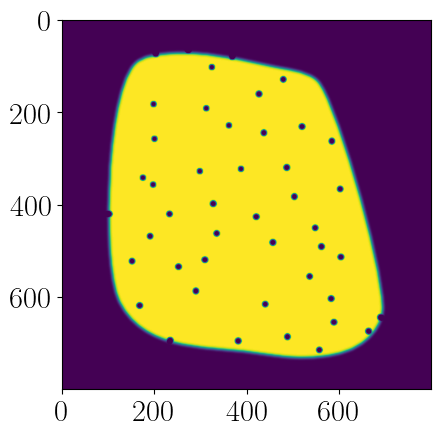

In [11]:
#####
N_runs = 400
mask_file = 'mask_simple800x800.png'
psfile = 'point_sources_800x800.png'
psapod = 1
#####

#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread(mask_file))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread(psfile))
point_sources = gaussian_filter(point_sources, psapod) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)

plt.imshow(apodized_mask)
plt.savefig('figures/apodized_masked_%dx%d.pdf'%(nX, nY),bbox_inches='tight')

In [12]:
f = open(UNMASKED_DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()
for key in data:
    print(key, np.shape(data[key]))

cmb0F_1 (100, 800, 401)
kCmbF_1 (100, 800, 401)
lCmbF_1 (100, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (100, 800, 401)
noiseF_1 (100, 800, 401)
totalF_1 (100, 800, 401)
totalF_0 (100, 800, 401)


In [16]:
from tqdm import trange,tqdm 
import pickle

masked_data = {}
for key in tqdm(data):
    c_key = key+'_m'
    c_data = np.array([
        baseMap.fourier(baseMap.inverseFourier(data[key][run_n])*apodized_mask)
        for run_n in range(len(data[key]))
    ])
    print(c_key, np.shape(c_data))
    masked_data[c_key] = c_data

  9%|▉         | 1/11 [00:04<00:40,  4.05s/it]

cmb0F_1_m (100, 800, 401)


 18%|█▊        | 2/11 [00:08<00:36,  4.07s/it]

kCmbF_1_m (100, 800, 401)


 27%|██▋       | 3/11 [00:11<00:31,  3.97s/it]

lCmbF_1_m (100, 800, 401)


 36%|███▋      | 4/11 [00:16<00:28,  4.04s/it]

lCmbF_o1_1_m (100, 800, 401)


 45%|████▌     | 5/11 [00:20<00:24,  4.12s/it]

lCmbF_o2_1_m (100, 800, 401)


 55%|█████▍    | 6/11 [00:24<00:20,  4.17s/it]

lCmbF_o3_1_m (100, 800, 401)


 64%|██████▎   | 7/11 [00:29<00:17,  4.29s/it]

lCmbF_o4_1_m (100, 800, 401)


 73%|███████▎  | 8/11 [00:33<00:12,  4.14s/it]

fgF_1_m (100, 800, 401)


 82%|████████▏ | 9/11 [00:37<00:08,  4.23s/it]

noiseF_1_m (100, 800, 401)


 91%|█████████ | 10/11 [00:41<00:04,  4.23s/it]

totalF_1_m (100, 800, 401)


100%|██████████| 11/11 [00:45<00:00,  4.17s/it]

totalF_0_m (100, 800, 401)


In [18]:
print(DATA_FNAME)

/data/delon/LensQuEst/map_sims_800x800_20x20_masked.pkl


In [19]:
f = open(DATA_FNAME, 'wb') 
p = pickle.Pickler(f) 
p.fast = True 
p.dump(data)
f.close()